# tRNA sequencing - data processing example

This notebook is an example of processing raw data from tRNA sequencing.
It starts from raw paired-end reads and concludes with a datafile containing counts of tRNA transcripts, with information about amino acids, codons, charge etc. and broken down based on sample name, replicate etc.
Some generically useful plots will be generated, such as: logo plots of the UMI sequences and non-template bases, plots showing the transcript/codon coverage and charge per sample.



## Setup - no need to change
Setting up folders, alignment setting, sequence information etc.
There should be no need to change these setting if the raw bz2 compressed data is stored in a folder named `data/raw_fastq`.


### Importing external packages

In [37]:
# These magic cells reloads imported code when it changes.
# Very useful for prototyping, other will do nothing.
%load_ext autoreload
%autoreload 2

### General imports ###
import os, sys, shutil, bz2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import logomaker as lm
from cycler import cycler
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

from wand.image import Image as WImage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting home directory
Navigate back to `NBdir` when re-running this code block.

In [2]:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/example


Define the path to the repo folder and insert it to the system path to enable code import from the `src/` folder.
__If the repo structure is changed this may need to be edited.__

In [3]:
homedir = '/'.join(NBdir.split('/')[0:-2])
assert(os.path.isdir(homedir))
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)

Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


### Importing internal code
Import all the relevant classes and functions from the `src/` folder:

In [4]:
from src.misc import index_to_sample_df, downsample_raw_input, read_tRNAdb_info, sample_df_to_dict
from src.read_processing import AR_merge, BC_split, Kmer_analysis, BC_analysis, UMI_trim
from src.alignment import SWIPE_align
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.transcript_mutations import TM_analysis

### Specify input
Default folder names for data and raw fastq files relative to the folder in which this notebook is in.
In this example all the output data should be put in the `data_dir` called `data` and the raw fastq files are stored in the `raw_fastq` folder, under the `data` folder.

In [5]:
data_dir = 'data'
seq_dir = 'raw_fastq'
seq_dir_noDS = seq_dir # Not downsampled
assert(os.path.isdir('{}/{}/{}'.format(NBdir, data_dir, seq_dir)))

The tRNA database is specied as a dictionary with keys for the different species:

In [6]:
tRNA_database = dict()
tRNA_database['human'] = '{}/tRNA_database/human/hg38-tRNAs.fa'.format(homedir)
tRNA_database['mouse'] = '{}/tRNA_database/mouse/mm10-tRNAs.fa'.format(homedir)
assert(all(os.path.isfile(db) for sp, db in tRNA_database.items()))
tRNA_database_masked = dict()
tRNA_database_masked['human'] = '{}/tRNA_database_masked/human/human-tRNAs.fa'.format(homedir)
assert(all(os.path.isfile(db) for sp, db in tRNA_database_masked.items()))

tRNA sequencing yields many duplicated reads.
Adding these commonly seen sequences to a list prevents running the same alignments again and again.
This is optional.

In [7]:
# common_seqs = '{}/utils/common-seqs.fasta.bz2'.format(homedir)
# ^^ That one is big an comprehensive, good for a full scale run
# with >1e6 reads per sample. For this example though it is going to
# be a bottleneck for alignment so instead take the top 1k:
common_seqs = '{}/utils/common-seqs_1k.fasta.bz2'.format(homedir)
assert(os.path.isfile(common_seqs))

Scoring matrices for SWIPE alignemnt.
Matrix one is a standard +1 for match and -2 for mismatch.
Matrix two is similar, but also rewarding match to a "masked" nt. marked by the character "N".

In [8]:
SWIPE_score_mat = '{}/utils/nuc_score-matrix.txt'.format(homedir)
SWIPE_score_mat2 = '{}/utils/nuc_score-matrix_2.txt'.format(homedir) # For masked reference sequences
assert(os.path.isfile(SWIPE_score_mat))
assert(os.path.isfile(SWIPE_score_mat2))

Excel file to specify the sequence barcodes/indices e.g. the sequence of Illumina D501 index and the barcode sequence of each adapter.

In [9]:
index_list_fnam = 'index_list.xlsx'
index_list_path = '{}/utils/{}'.format(homedir, index_list_fnam)
assert(os.path.isfile(index_list_path))

### Specify output directories
These folder names are used in subsequent processing steps to dump data into the `data_dir`.
Best to not change if you want to reload the data from past processing.

In [10]:
AdapterRemoval_dir = 'AdapterRemoval'
BC_dir = 'BC_split'
UMI_dir = 'UMI_trimmed'
align_dir = 'SWalign'
stats_dir = 'stats_collection'
TM_dir = 'transcript_mutations'
plotting_dir = 'plotting'

### Specify setting for read length and alignment
Define minimum read length based on minimum insert size.

In [11]:
MIN_INSERT_LEN = 10
UMI_LEN = 10
BC_MAX_LEN = 19
MIN_READ_LEN = MIN_INSERT_LEN + UMI_LEN + BC_MAX_LEN
print('Using minimum read length: {} (after merge)'.format(MIN_READ_LEN))

Using minimum read length: 39 (after merge)


The minimum alignment score.
The alignment score is calculated as 1 per match, -2 per mismatch, -6 per gap opening and -1 per gap extension.
Better to set relatively low, since additional filtering can be applied later.

In [12]:
MIN_SCORE_ALIGN = 15
print('Using minimum alignemnt score: {}'.format(MIN_SCORE_ALIGN))

Using minimum alignemnt score: 15


### Read some global input

In [13]:
# Read tRNA database information (length, codon etc) into dictionary:
tRNA_data = read_tRNAdb_info(tRNA_database)
# Read index information into dataframe:
index_df = pd.read_excel(index_list_path)

## Setup - sample specific
A sample list is defined in an Excel file, in this case named `sample_list.xlsx`.
Here, specify the filename, load it and show the first few rows:

In [14]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
sample_df.head(2)

,sample_name_unique,sample_name,replicate,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order
0,100p,100p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l2Sp,human,Charge-titration,Percent charge,100p,1
1,85p,85p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l4Sp,human,Charge-titration,Percent charge,85p,2


To this sample list dataframe add barcode and Illumina index sequences from the index dataframe:

In [15]:
sample_df = index_to_sample_df(sample_df, index_df)

Extract the filename for the paired-end mates to merge.
In this example there is only one:

In [16]:
# Get filenames from the sample information:
inp_file_df = sample_df[['fastq_mate1_filename', 'fastq_mate2_filename', 'P5_index', 'P7_index', 'P5_index_seq', 'P7_index_seq']].copy().drop_duplicates().reset_index(drop=True)
inp_file_df

,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,P5_index_seq,P7_index_seq
0,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,AGGCTATA,CGCTCATT


### Downsampling for quick first-pass processing
This example has 500,000 paired-end reads per file under `data/raw_fastq`.
This is a small amount spread over the multiple samples that have been barcoded and pooled, but it is enough for an example.

In a typical real run each sample has >1e6 reads and a total of more than 100 samples are pooled.
Even simple tasks like uncompressing this amount of reads take a long time.
To quickly check the integrity of the data, whether settings are right etc. it is possible to downsample each datafile using the `downsample_raw_input` function.

It is highly recommended to do a run on downsampled data first e.g. downsampled to 1e4 reads per file.
That way any error will be detected quickly and when results are satisfactory on the downsampled data the workflow can be performed on the full size data with confidence.

Because this is an example there is no need to downsample the data first; however for reference, below is an example on how to call the `downsample_raw_input` function and downsample to 1e4 reads per file.

In [17]:
if False:
    sample_df, inp_file_df, seq_dir = downsample_raw_input(sample_df, inp_file_df, NBdir, data_dir, seq_dir_noDS, downsample_absolute=1e4)

### Paths for input/output
Make a dictionary with paths used for data processing:

In [18]:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                seq_dir = seq_dir,
                AdapterRemoval_dir = AdapterRemoval_dir,
                BC_dir = BC_dir,
                UMI_dir = UMI_dir,
                align_dir = align_dir,
                stats_dir = stats_dir,
                TM_dir = TM_dir,
                plotting_dir = plotting_dir)

## Process tRNA sequencing reads

### Adapter removal and merging
Run AdapterRemoval software to trim off any remaining Illumina adapters (if that has not already been done) and merge the paired-end reads:

In [19]:
# Initiate the AdapterRemoval object:
AR_obj = AR_merge(dir_dict, inp_file_df, MIN_READ_LEN, overwrite_dir=True)
# Start AdapterRemoval (here n_jobs is irrelevant because there is only one input file pair):
inp_file_df = AR_obj.run_parallel(n_jobs=4, overwrite=True)

Statistics about the merging has now been added to the `inp_file_df` dataframe.
Typically, >90 % of all reads are successfully merged.

In [20]:
inp_file_df

,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,P5_index_seq,P7_index_seq,N_pairs,N_merged,percent_successfully_merged
0,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,AGGCTATA,CGCTCATT,551564,533567,96.737097


### Sample splitting
Now, each merged file (only one for this example) contains reads from several adapter barcoded samples.
In the following code block the merged file is split into sample specific files.

In [21]:
# Initiate the barcode splitting object:
BCsplit_obj = BC_split(dir_dict, sample_df, inp_file_df, overwrite_dir=True)
# Split the files (again, n_jobs is irrelevant because there is only one input file):
sample_df, inp_file_df = BCsplit_obj.run_parallel(n_jobs=4)

New columns of statistics have been added to the `inp_file_df` dataframe.
Typically, >90 % of all merged reads will be successfully mapped to a barcode and split.
In this example only 76 % of reads were mapped, below will investigate why.

In [22]:
inp_file_df

,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,P5_index_seq,P7_index_seq,N_pairs,N_merged,percent_successfully_merged,N_BC-mapped,N_BC-unmapped,N_sum-check,percent_BC-mapped
0,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,AGGCTATA,CGCTCATT,551564,533567,96.737097,425049,108518,533567,79.661786


Statistics have also also been added to the `sample_df` dataframe.
For example the total number of reads for the sample (N_total) and how many ended on CC vs. CCA.
Since all mature tRNAs end on CCA, and oxidation and 3' cleavage generates 3' CC, the percentage of CCA+CC vs. total reads is a good indidator of sample purity; it is typically >95 %.
The percentage of CCA ending sequences (vs. CCA+CC ending) can be interpreted as the bulk charge

In [23]:
sample_df

,sample_name_unique,sample_name,replicate,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA
0,100p,100p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,42717,2279,40087,42366,99.178313,94.620686
1,85p,85p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l4Sp,human,Charge-titration,Percent charge,85p,2,AGGCTATA,CGCTCATT,GGCTGCCATGCAAGCTG,41307,9872,31072,40944,99.121214,75.889019
2,70p,70p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l6Sp,human,Charge-titration,Percent charge,70p,3,AGGCTATA,CGCTCATT,GGCTGCCATGCTACAG,52721,23268,29050,52318,99.235599,55.525823
3,47p,47p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l9Sp,human,Charge-titration,Percent charge,47p,4,AGGCTATA,CGCTCATT,GGCTGCCATGCAACGTACA,106282,67658,37733,105391,99.161664,35.802867
4,40p1,40p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l3Sp,human,Charge-titration,Percent charge,40p,5,AGGCTATA,CGCTCATT,GGCTGCCATGCTGCGA,43159,30957,11883,42840,99.260873,27.738095
5,40p2,40p,2,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l5Sp,human,Charge-titration,Percent charge,40p,5,AGGCTATA,CGCTCATT,GGCTGCCATGCAACGCATC,42017,29964,11758,41722,99.297903,28.181775
6,10p,10p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l1Sp,human,Charge-titration,Percent charge,10p,6,AGGCTATA,CGCTCATT,GGCTGCCATGCGACTA,44901,41765,2760,44525,99.162602,6.198765
7,0p,0p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l7Sp,human,Charge-titration,Percent charge,0p,7,AGGCTATA,CGCTCATT,GGCTGCCATGCACATGA,51945,51203,318,51521,99.183752,0.617224


### Looking at unmapped reads
Since the above mapping percentage was low we can run analysis on the unmapped reads to see if there is a pattern at the end of the reads were the adapter sequences was supposed to be.

The most basic way of doing this is by counting Kmers:

In [24]:
### Perform Kmer analysis on unmapped reads ###
if True: # barcode analysis is typically suficient 
    # Initiate the Kmer analysis object:
    kmer_obj = Kmer_analysis(dir_dict, inp_file_df, index_df, overwrite=True)
    # Add a filter to avoid Kmers from the end of tRNA sequences:
    kmer_obj.filter_3p_fasta(tRNA_database['human'])
    # Add to this filter the constant region of the adapters:
    kmer_obj.filter_window_BC(filter_window=(0, 11))
    # Search for Kmers:
    all_kmer = kmer_obj.search_unmapped(search_size=13)

In the output table below each Kmer is listed with its count and distance to a known barcode (as defined in the index list input).
It would seem that a lot of reads have Kmers similar to those found in adapter l11Sp...

In [25]:
all_kmer.head(8)

,Kmer,Count,Barcode distance,Barcode
0,TGCAA,90641,0.0,l4Sp
1,GCAAC,57033,0.0,l5Sp
2,AACCT,54617,0.0,l11Sp
3,CTGAT,54584,0.0,l11Sp
4,CCTGA,54453,0.0,l11Sp
5,ACCTG,54435,0.0,l11Sp
6,GCAAG,33330,0.0,l4Sp
7,CAAGT,32824,0.0,l10Sp


Another way, typically more useful, of looking into the unmapped reads is to look for the barcode sequences directly.

Recall that adapters look like this:  
``GGCTGCCATGC    GACTA``  
``GGCTGCCATGCA   AGTGC``  
``GGCTGCCATGCTG  TCACG``  
``GGCTGCCATGCAAC CTGAT``  
With the barcode as the rightmost 5 nt.
Search these 5 nt. barcodes by specifying `BC_size_3p=5`.

In [26]:
# Initiate the barcode analysis object:
bc_analysis_obj = BC_analysis(dir_dict, inp_file_df, index_df, BC_size_3p=5, overwrite=True)
# Search for barcodes in the unmapped reads.
# For the summary output, filter by a max distance
# to any barcode of 1 (group_dist=1), then group by barcode name:
bc_analysis_df = bc_analysis_obj.search_unmapped(group_dist=1)

The grouped counts can be seen in the output and again suggests presence of l10Sp and l11Sp, but also l12Sp and l3Sp to a lesser extend:

In [27]:
bc_analysis_df.head(4)

,Name,Count
0,l11Sp,54405
1,l10Sp,32259
2,l12Sp,7391
3,l3Sp,3253


And more detailed information can be gleaned in the `bc_df` attribute which shows that the high number for l5Sp shown above is mostly due to observations with distances 1 from the barcode counted because of the `group_dist=1` flag.

In [28]:
bc_analysis_obj.bc_df.head(7)

,Name,Barcode,Target,Count,Distance
0,l11Sp,CTGAT,CTGAT,54322,0
1,l10Sp,AGTGC,AGTGC,32226,0
2,l12Sp,GTGAC,GTGAC,7368,0
3,l9Sp,GTACA,GTACA,1678,0
4,l3Sp,TGCGA,TGCGA,1124,0
5,l7Sp,CATGA,CATGA,1060,0
6,l5Sp,GCATC,GCATC,709,0


The full output, grouped and not, can be found in the barcode split data folder in the two folders `Kmer_analysis` and `BC_analysis`.
The explanation for the low mapping and the above findings is that the input file actually _do_ have samples barcoded with l10Sp, l11Sp and l12Sp even though these samples have not been defined in the samples sheet `sample_list.xlsx`.
Thus, the use of Kmer and/or barcode analysis could be used to identify any mislabelling, bad adapters etc.

### Trimming UMI
The reverse transcription was performed with an oligo containing a 10 nt. unique molecular identifier (UMI).
Typically, UMIs are employed to collaped reads from the same molecule when over-sequencing a library made from a very small amount of starting material.
For tRNA sequencing the amount of starting material should be so high that no tRNA molecular is sequenced twice; however, if there were bottlenecks in the library prep that assumption could prove false.
The UMI employed for tRNA sequencing as a quality control for library prep.
It also helps to diversify the start of the read, thereby increasing Illumina sequencing quality, and it randomizes the sequence context for circular ligation, decreasing ligation bias.

But we also need to get rid of it before alignment.

In [29]:
# Initiate the UMI trimming object:
UMItrim_obj = UMI_trim(dir_dict, sample_df, overwrite_dir=True)
# Run the UMI trimming in parallel (increase n_jobs to number of processor):
sample_df = UMItrim_obj.run_parallel(n_jobs=4)

UMI trimming statistics have been added to the `sample_df` dataframe.
Typically, >95 % of all barcode split reads have a valid UMI sequence i.e. the UMI ends on T or C.

Observe, that the _expected_ number of observed UMIs have been calculated given the length of the UMI and the number reads with valid UMIs.
The percentage of observed vs. expected UMIs is a good validation that the library prep was successful.
It should not be expected to be 100 % because random bases in oligos are [not completely random](https://www.idtdna.com/pages/products/custom-dna-rna/mixed-bases); however, it should typically be >90 %.
Be aware though, that the observed vs. expected UMI percentage depends on the sampling depth and thus downsampling will likely change this number.
Downsampling using the `downsample_absolute` option could also cause lower percentages because it samples from the top of the fastq file (for speed reasons) and thus not randomly.
Use the `downsample_fold` option for true random sampling.
For an example of how the number of reads affect this see the `utils/code-of-limited-use` folder and check the `UMI_count_analysis` notebook.

In [30]:
sample_df.head(3)

,sample_name_unique,sample_name,replicate,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp
0,100p,100p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,42717,2279,40087,42366,99.178313,94.620686,41950,39541,40315.638763,98.204462,98.078565
1,85p,85p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l4Sp,human,Charge-titration,Percent charge,85p,2,AGGCTATA,CGCTCATT,GGCTGCCATGCAAGCTG,41307,9872,31072,40944,99.121214,75.889019,40570,38381,39040.076003,98.215799,98.311796
2,70p,70p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l6Sp,human,Charge-titration,Percent charge,70p,3,AGGCTATA,CGCTCATT,GGCTGCCATGCTACAG,52721,23268,29050,52318,99.235599,55.525823,51830,48245,49350.518375,98.309971,97.759865


### Align sequences
Now, the sequences are ready for alignment.
This done using [SWIPE](https://github.com/torognes/swipe/), which is a fast implementation of the Smith-Waterman algorithm.
The gap en gap extension penalties can be adjusted when initiating the alignment object and the match/mismatch score can be adjusted in the score matrix defined in the input above.
However, the current defualt values have been tested and work well so adjustment should not be necessary.

If `common_seqs` is specified, these sequences, when found in each sample, will be counted, skipped and first aligned at the end.
This prevents alignments of common sequences to be run many times and can shorten the alignment time drastically.
When alignment statistics is calculated the common sequences will be added with the their number of observations.

Running this cell should be the slowest computation in this example.
It may take a few minutes to run.

In [31]:
# Initiate alignment object:
align_obj = SWIPE_align(dir_dict, tRNA_database_masked, sample_df, \
                        SWIPE_score_mat2, gap_penalty=6, extension_penalty=3, \
                        min_score_align=MIN_SCORE_ALIGN, common_seqs=common_seqs, \
                        overwrite_dir=True)
# Start the alignemnt:
sample_df = align_obj.run_parallel(n_jobs=4)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  85p  100p  70p  47p  40p2  40p1  10p  common-seqs  0p

Alignment statistics is added to the `sample_df` dataframe.
Typically, >95% of sequences are mapped and >70% of these have a single annotation.
Those sequences with multiple annotations have exactly the same alignment score when aligned to multiple reference sequences which often happens when there exists multiple transcripts of a tRNAs with the same codon.
The `percent_multiple_codons` quantifies the extend of the more problematic case when the multiple annotations come from transcripts with different codons.
This should only be less than 10% of mapped reads.

In [32]:
sample_df.head(3)

,sample_name_unique,sample_name,replicate,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,percent_multiple_codons,Mapping_percent
0,100p,100p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,42717,2279,40087,42366,99.178313,94.620686,41950,39541,40315.638763,98.204462,98.078565,41481.0,75.861238,24.138762,3.760758,98.882002
1,85p,85p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l4Sp,human,Charge-titration,Percent charge,85p,2,AGGCTATA,CGCTCATT,GGCTGCCATGCAAGCTG,41307,9872,31072,40944,99.121214,75.889019,40570,38381,39040.076003,98.215799,98.311796,40247.0,76.035481,23.964519,3.736924,99.203845
2,70p,70p,1,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l6Sp,human,Charge-titration,Percent charge,70p,3,AGGCTATA,CGCTCATT,GGCTGCCATGCTACAG,52721,23268,29050,52318,99.235599,55.525823,51830,48245,49350.518375,98.309971,97.759865,51466.0,76.953717,23.046283,3.579062,99.297704


### Collect alignment statistics
The alignment results are stored in large JSON files that are practical for parsing but not for data manipulation, plotting etc.
Therefore, it is necessary to collect statistics, add sample information, add UMI info and many more things.
Notice the `common_seqs` argument is also used to fill out the common sequences that were separated out during the alignment phase.

In [33]:
# Initiate the stats collection object:
stats_obj = STATS_collection(dir_dict, tRNA_data, \
                             sample_df, common_seqs=common_seqs, \
                             overwrite_dir=True)
# Start collecting stats for each sample:
stats_df = stats_obj.run_parallel(n_jobs=4)

Using common sequences...

The statistics is written, per read, as a bz2 compressed .csv file; however, many of the entries in this table will be duplicates and only different by different fastq read ID and UMI sequence.
Therefore, another uncompressed table is made that aggregates all the row that are identical except differing read ID and UMI.

After statistics have been collected for all samples a concatenation of the aggregated data from all samples is made with the name `ALL_stats_aggregate.csv`.
This file is particularly useful because it is relatively compact but contains all information from all samples.

The dataframe returned is the `ALL_stats_aggregate_filtered.csv` which is the aggregated data filtered to contain only the most relevant columnns and requiring that the 3' must be covered and have no 3' non-template bases.

In [34]:
stats_df.head(8)

,sample_name_unique,sample_name,replicate,barcode,species,tRNA_annotation,tRNA_annotation_len,unique_annotation,5p_cover,align_3p_nt,codon,anticodon,amino_acid,align_gap,fmax_score>0.9,count,UMIcount
0,100p,100p,1,l2Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,C,AAA,TTT,eColiLys,False,False,1,1
1,100p,100p,1,l2Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,C,AAA,TTT,eColiLys,False,True,13,13
2,100p,100p,1,l2Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,C,AAA,TTT,eColiLys,True,False,2,2
3,100p,100p,1,l2Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,True,A,AAA,TTT,eColiLys,False,True,1,1
4,100p,100p,1,l2Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,True,C,AAA,TTT,eColiLys,False,True,9,9
5,100p,100p,1,l2Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,True,C,AAA,TTT,eColiLys,True,False,2,2
6,100p,100p,1,l2Sp,human,Homo_sapiens_mito_tRNA-Ala-TGC,72,True,False,A,GCA,TGC,Ala,False,False,1,1
7,100p,100p,1,l2Sp,human,Homo_sapiens_mito_tRNA-Ala-TGC,72,True,False,A,GCA,TGC,Ala,False,True,35,35


### Plotting the results
Next, the data can be plotted in order to 1) inspect the data quality and 2) get an overview of the relative tRNA expression and charge.
For this the `TRNA_plot` class was made.
This class allows us to generate some standard plots that are useful for most experiments involving tRNA sequencing.
It utilizes the information in the `sample_df` dataframe to group samples onto the same plot.

The class can the initiated with exclusion filters based on alignment score or alignment gap content and using UMI or read counts.
By using UMI counts instead of read counts, we can correct for PCR duplications; however, typically there is not a big difference between the UMI or read counts.

In [67]:
# Initiate the plotting object:
plot_obj = TRNA_plot(dir_dict, sample_df, use_UMIcount=False, overwrite_dir=True)

Inspired by the coverage plots in Behrens et al. 2021, we could start by plotting the sequence coverage broken down by the amino acid identity of the transcript.
To plot all transcripts on a single plot it is necessary to scale the transcript length such that all are equal.
This scaling is done by mapping all transcripts to the longest transcript.

Below, a Behrens style coverage plot is shown, normalized on the y-axis such that coverage is shown as a percentage of the coverage at the 3' of the transcript.
It shows nicely how the coverage decreases further into the transcript and drops off at particular points which are associated with commonly modified positions.
It also shows the relative abundance of transcripts of an amino acid e.g. higher relative abundance of alanine (A) compared to tryptophan (W).


Now collecting data for sample:  100p  85p  70p  47p  40p1  40p2  10p  0p
Now plotting sample:  100p  85p  70p  47p  40p1  40p2  10p  0p

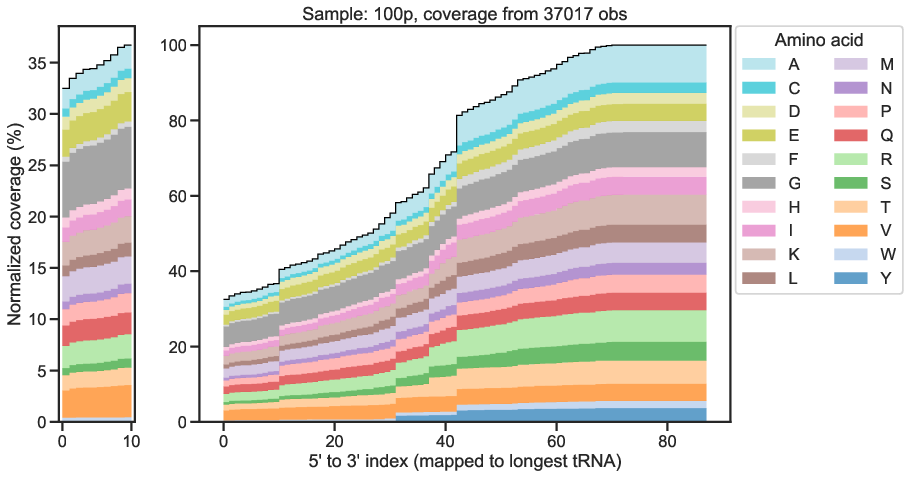

In [68]:
plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', y_norm=True, \
                       plot_name='cov-plot_cyto_behrens_norm')
img = WImage(filename='data/plotting/cov-plot_cyto_behrens_norm.pdf[0]')
img

Sometimes, it may be desirable to focus on the coverage drop off and show more explicitly the fraction of reads that fully cover a transcript.
For this, we can normalize the coverage such that the difference in relative abundance between different amino acids is equalized.
Furthermore, a different style plot can be generated to enhance the view of coverage drop off.
This plot is referred to as a "needle plot"

Below, such a needle plot is shown.
It clearly shows that the valine transcript (V) has a high read-through while the tryptophan transcript (W) has a very low read-through with two points with large coverage drop off.


Now collecting data for sample:  100p  85p  70p  47p  40p1  40p2  10p  0p
Now plotting sample:  100p  85p  70p  47p  40p1  40p2  10p  0p

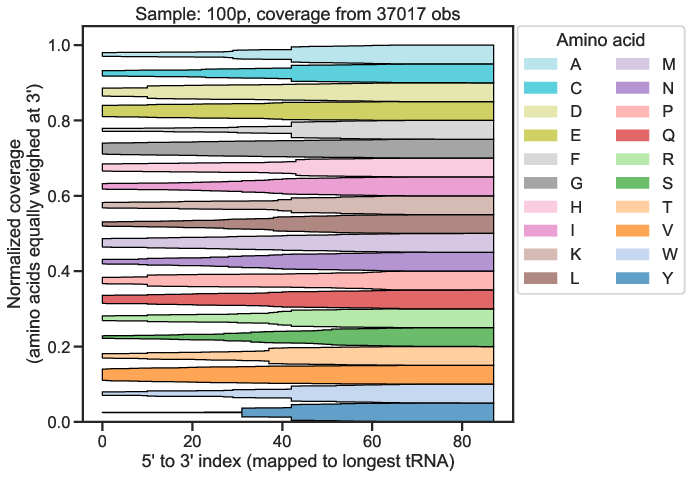

In [69]:
plot_obj.plot_coverage(compartment='cyto', plot_type='needle', aa_norm=True, \
                       plot_name='cov-plot_cyto_needle_aa-norm')
img = WImage(filename='data/plotting/cov-plot_cyto_needle_aa-norm.pdf[0]')
img

A common standard plot is a simple view of the relative expression level broken down by either transcript, codon or amino acid identity.
This plot is generated below:


Now plotting sample/group:  Charge-titration
Now plotting sample/group:  100p  85p  70p  47p  40p  10p  0p

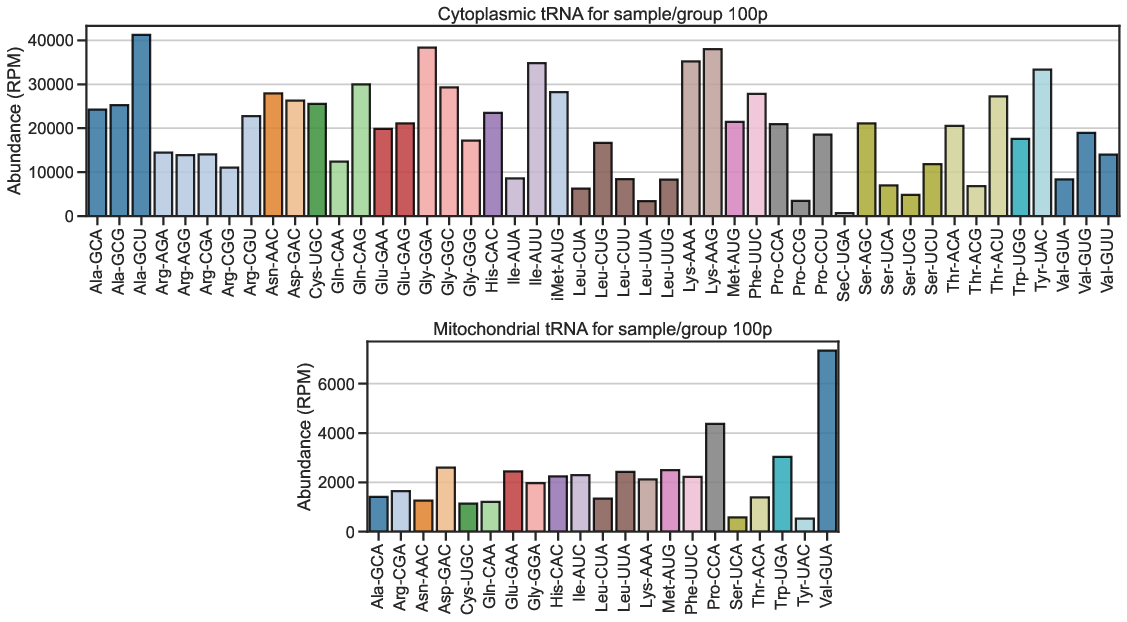

In [70]:
# Grouped plot:
plot_obj.plot_abundance(plot_name='abundance-plot_codon_grp', group=True, \
                        plot_type='codon', min_obs=10)
# Individual sample plot:
plot_obj.plot_abundance(plot_name='abundance-plot_codon', group=False, \
                        plot_type='codon', min_obs=10)
img = WImage(filename='data/plotting/abundance-plot_codon.pdf[0]')
img

Another standard plot is one showing the tRNA charge.
Such a plot, broken down by amino acid and grouped, is shown below:


Now plotting sample/group:  Charge-titration
Now plotting sample/group:  Charge-titration

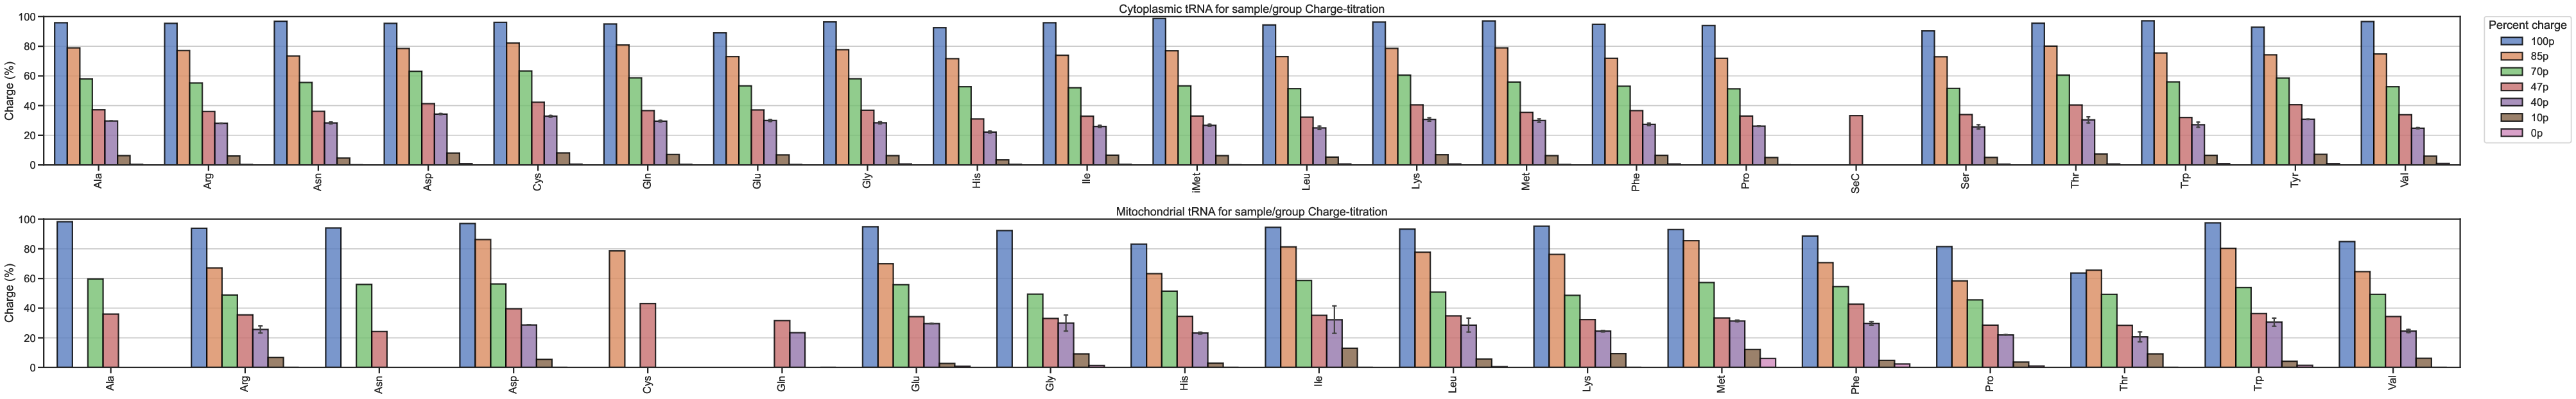

In [71]:
# Grouped plot, per codon:
plot_obj.plot_abundance(plot_name='charge-plot_codon_grp', group=True, \
                        plot_type='codon', min_obs=50, charge_plot=True)
# Grouped plot, per amino acid:
plot_obj.plot_abundance(plot_name='charge-plot_aa_grp', group=True, \
                        plot_type='aa', min_obs=50, charge_plot=True)
img = WImage(filename='data/plotting/charge-plot_aa_grp.pdf[0]')
img

Sometimes, it can be useful to plot the relative abundance of two samples in comparison to each other.
For example, for replicates or samples that should have the same relative abundance, the RPM values should fall on a straight line.
This is plotted below, with each transcript as a datapoint, a linear regression line in blue and a one-to-one correspondance as a red line:


Now plotting sample pairs:  (100p - 10p)  (100p - 0p)

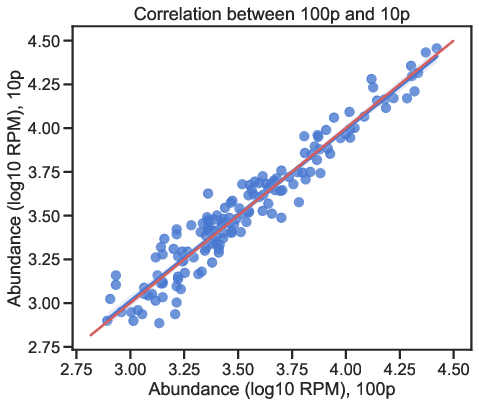

In [72]:
plot_obj.plot_abundance_corr(sample_unique_pairs=[['100p', '100p'], ['10p', '0p']], \
                             plot_type='transcript', charge_plot=False, log=True, \
                             plot_name='abundance-corr-plot_tr', \
                             min_obs=30)
img = WImage(filename='data/plotting/abundance-corr-plot_tr.pdf[0]')
img

A similar plot can be made showing charge instead of RPM:


Now plotting sample pairs:  (40p1 - 40p2)

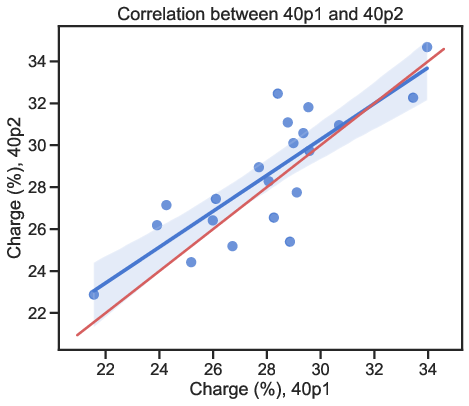

In [73]:
plot_obj.plot_abundance_corr(sample_unique_pairs=[['40p1'], ['40p2']], \
                             plot_type='aa', charge_plot=True, log=False, \
                             plot_name='charge-corr-plot_aa', \
                             min_obs=500, one2one_corr=True)
img = WImage(filename='data/plotting/charge-corr-plot_aa.pdf[0]')
img

Finally, we can look into some of the features of the library prep.
First, let us plot a logo over the positional nucleotide use of the UMI:


Now collecting data for sample:  100p  85p  47p  70p  40p2  40p1  10p  0p
Now plotting logo plot.

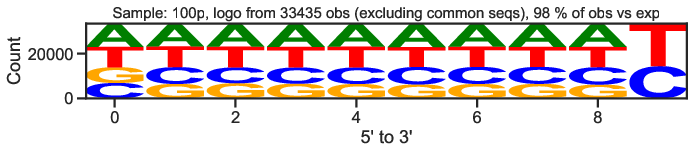

In [74]:
plot_obj.plot_UMI_logo(plot_name='UMI_logo')
img = WImage(filename='data/plotting/UMI_logo.pdf[0]')
img

The UMI logo plot shows approxiamate random nucleotide use on all positions except the 3' nt. which is always a random pyrimidine.
This is also what should be expected given the RT oligo design.

Next, we can plot the 5' non-template nucleotides.
These are added to the end of the cDNA by the reverse transcriptase during the RT-PCR reaction.
Here, we only include up to the 99th percentile of the longest 5' non-template nucleotide additions:


Now collecting data for sample:  85p  100p  70p  47p  40p2  40p1  10p  0p
Now plotting logo plot.

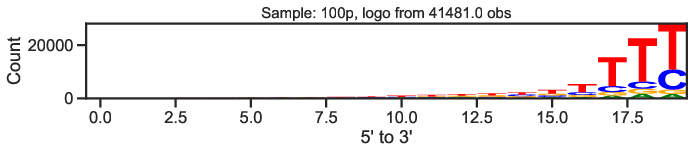

In [75]:
plot_obj.plot_non_temp(end='5p', plot_name='_5p-non-template_logo', \
                       seq_len_percentile=99)
img = WImage(filename='data/plotting/_5p-non-template_logo.pdf[0]')
img

We observe that the most commonly observed 5' non-template nucleotide is T, which means that the reverse transcriptase adds A to the 3' of the cDNA.
This is similar to the observation made by Behrens et al. 2021.

Next, we can look at the 3' non-template nucleotides.
These are not added by the reverse transcriptase but are likely either erronous CCA additions or additional bases in the adapter.
Plotted below and only showing sequences with 3' coverage:


Now collecting data for sample:  100p  85p  70p  47p  40p2  40p1  10p  0p
Now plotting logo plot.

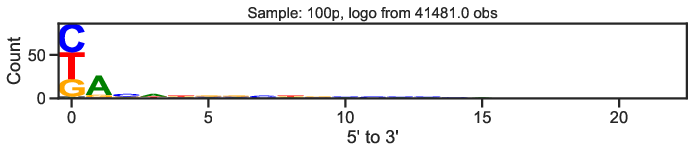

In [76]:
plot_obj.plot_non_temp(end='3p', plot_name='_3p-non-template_logo', \
                       seq_len_percentile=99.9, _3p_cover=True)
img = WImage(filename='data/plotting/_3p-non-template_logo.pdf[0]')
img

From this, we can see that 3' non-template nucleotides are a rare occurence with mostly one or two nucleotides added.
Had there been many more sequences with 3' non-template nucleotides it would have indicated a problem, possibly with the quality of the adapter oligo.

Before moving on, we can dump the charge and relative abundance data to enable custom plotting:

In [79]:
# Write charge/RPM data grouped by transcript, codon and amino acid:
plot_obj.write_charge_df(df_type='transcript', \
                         fnam='charge-df_tr')
plot_obj.write_charge_df(df_type='codon', \
                         fnam='charge-df_codon')
plot_obj.write_charge_df(df_type='aa', \
                         fnam='charge-df_aa')

In [ ]:
# Use the TM_analysis to find the most mutated positions in the tRNA transcripts.
# Then generate a new version of the tRNA transcripts database with these positions masked
# Then, using the masked sequences, re-run the alignment, stats collected and plotting

# Re-run using gap_open = -3 and gap_extension = -2 to reflect how gaps are more tolerated

### The masked tRNA database will only be used for alignment
# All other steps will use the old unmasked database

In [623]:
### Perform transcript mutation analysis ###
TM_obj = TM_analysis(dir_dict, sample_df, tRNA_database, pull_default=True, common_seqs=common_seqs, ignore_common_count=True)
TM_dir_abs = TM_obj.make_dir(overwrite=True)

#TM_obj.find_muts(n_jobs=4, sample_list=['70p1', '70p2', '70p3', '70p4'])
TM_obj.find_muts(n_jobs=4, unique_anno=True)
#TM_obj.find_muts(n_jobs=4)
TM_obj.fix_end()

#TM_obj.plot_transcript_logo()



# tr_mut_out = TM_obj.plot_transcript_mut(topN=30, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat', min_count_show=10)
#tr_mut_out = TM_obj.plot_transcript_mut(topN=30, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat2')


#tr_cov_out = TM_obj.plot_transcript_cov(topN=40, no_plot_return=False, mito=False, plot_name='test_heat_cov', sort_rows=True)
#tr_mut_out = TM_obj.plot_transcript_mut(topN=40, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat2', sort_rows=tr_cov_out[2])


TM_obj.mask_tRNA_database(min_mut_freq=0.5, min_pos_count=50, min_tr_count=100, frac_max_score=0.90)

tRNA_database_masked = TM_obj.write_masked_tRNA_database(out_dir='tRNA_database_masked')

Using common sequences...

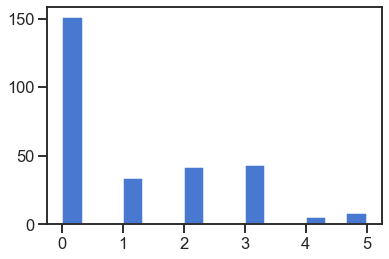

In [615]:
plt.hist(TM_obj.mask_stats['human']['mask_count'], bins=15);

In [616]:
TM_obj.mask_stats['human']

{'mask_count': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 5, 0, 0, 0, 5, 0, 3, 0, 3, 2, 3, 0, 5, 0, 3, 3, 2, 0, 3,
        3, 3, 3, 2, 0, 2, 5, 5, 4, 2, 2, 2, 2, 2, 2, 0, 2, 4, 2, 4, 0, 1,
        0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1,
        1, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0,
        0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 4, 4, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3, 3,
        3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2]),
 'mask_sum': 307,
 'mask_mean':

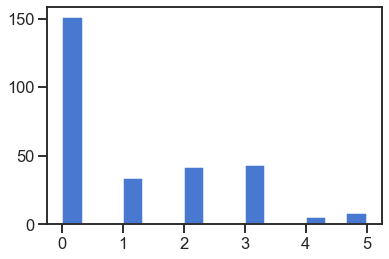

In [617]:
plt.hist(TM_obj.mask_stats['human']['mask_count'], bins=15);

In [576]:
TM_obj.mask_stats['human']

{'mask_count': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  5,  0,  0,  0,  5,  0,  4,  0,  4,
         0,  4,  0,  5,  0,  4,  4,  0,  0,  5,  5,  5,  5,  3,  0,  3,  5,
         5,  4,  2,  0,  0,  0,  0,  0,  0,  0,  4,  0,  4,  0,  0,  0,  0,
         0,  0,  5,  0,  0,  0,  5,  5,  0,  0,  0,  5,  5,  5,  5,  4,  0,
         5,  4,  2,  2,  2,  2,  3,  3,  2,  3,  3,  3,  2,  3,  3,  2,  3,
         3,  3,  0,  0,  3,  3,  3,  2,  3,  3,  3,  2,  2,  2,  2,  2,  0,
         0,  3,  3,  3,  0,  1,  1,  3,  5,  3,  5,  5,  1,  1,  0,  1,  1,
         1,  0,  0,  1,  1,  1,  1,  2,  4,  0,  4,  4,  4,  4,  4,  4,  3,
         0,  0,  3,  3,  3,  4,  4,  4,  4,  3,  3,  3,  3,  0,  0,  5,  5,
         2,  0,  0,  0,  4,  4,  0,  1,  0,  0,  1,  1,  1,  1,  0,  0,  0,
         1,  0,  4,  4,  4,  4,  1,  1,  0,  3,  0,  3,  3,  0,  0, 13, 13,
        13, 13,  0,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0

In [599]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database, sample_df, SWIPE_score_mat2, gap_penalty=3, extension_penalty=2, min_score_align=MIN_SCORE_ALIGN, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=True)
# sample_df = align_obj.run_serial(dry_run=False, verbose=False, overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=4)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  100p2  100p1  100p3  100p4  85p4  85p2  85p3  85p1  70p3  70p2  70p1  55p1  55p3  55p4  70p4  40p1  40p2  55p2  25p1  40p4  25p2  10p1  25p4  10p3  10p2  25p3  0p2  40p3  0p4  0p1  10p4  0p3  0p_90m4  0p_90m1  0p_90m2  0p_90m3  common-seqs

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-10k.fastq.bz2,P1_R2_DSA-10k.fastq.bz2,944,38,902,940,99.576271,95.957447,931,866,930.174768,98.622881,93.100784,922.0,74.511931,25.488069,99.033298
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-10k.fastq.bz2,P2_R2_DSA-10k.fastq.bz2,673,14,648,662,98.365527,97.885196,663,622,662.581602,98.514116,93.875230,653.0,73.813170,26.186830,98.491704
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-10k.fastq.bz2,P3_R2_DSA-10k.fastq.bz2,709,35,666,701,98.871650,95.007133,692,633,691.544180,97.602257,91.534282,674.0,72.848665,27.151335,97.398844


In [618]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database_masked, sample_df, SWIPE_score_mat2, gap_penalty=3, extension_penalty=2, min_score_align=MIN_SCORE_ALIGN, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=True)
# sample_df = align_obj.run_serial(dry_run=False, verbose=False, overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=4)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  100p1  100p3  100p2  100p4  85p4  85p2  85p3  70p3  85p1  70p1  70p2  55p1  55p2  55p4  40p1  70p4  40p2  55p3  40p3  25p3  25p4  10p1  25p1  25p2  10p4  10p2  10p3  40p4  0p2  0p1  0p3  0p4  0p_90m1  0p_90m3  0p_90m2  0p_90m4  common-seqs

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-10k.fastq.bz2,P1_R2_DSA-10k.fastq.bz2,944,38,902,940,99.576271,95.957447,931,866,930.174768,98.622881,93.100784,927.0,75.512406,24.487594,99.570354
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-10k.fastq.bz2,P2_R2_DSA-10k.fastq.bz2,673,14,648,662,98.365527,97.885196,663,622,662.581602,98.514116,93.875230,656.0,72.713415,27.286585,98.944193
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-10k.fastq.bz2,P3_R2_DSA-10k.fastq.bz2,709,35,666,701,98.871650,95.007133,692,633,691.544180,97.602257,91.534282,677.0,73.264402,26.735598,97.832370
